# MAST30034_Applied Data Science_Project1

## Import Libraries

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [2]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.config("spark.sql.session.timeZone", "Etc/UTC")
.getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/22 20:27:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read Data

In [3]:
taxi_data = spark.read.parquet('../data/data_after_preprocessing/taxi')
citybike_data = spark.read.parquet('../data/data_after_preprocessing/citybike')
weather_data = spark.read.parquet('../data/data_after_preprocessing/weather')

In [4]:
taxi_zones = gpd.read_file("../data/raw/NYCTLC_data/taxi_zone_shipfile/taxi_zones.shp")

In [5]:
taxi_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'duration']

In [6]:
citybike_data.columns

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'duration']

In [7]:
weather_data.columns

['name',
 'datetime',
 'temp',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'preciptype',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'severerisk',
 'conditions',
 'icon',
 'stations']

## Divide the data into the first nine months and the second two months

In [8]:
# the function use to spit the data
def split_data_by_date(data, date_column):
    start_date_1 = "2023-01-31"
    end_date_1 = "2023-11-01"
    start_date_2 = "2023-10-31"
    end_date_2 = "2024-01-01"
    split_1 = data.filter((F.col(date_column) > start_date_1) & (F.col(date_column) < end_date_1))
    split_2 = data.filter((F.col(date_column) > start_date_2) & (F.col(date_column) <= end_date_2))
    return split_1, split_2

In [9]:
taxi_data_9,taxi_data_2 = split_data_by_date(taxi_data, 'tpep_pickup_datetime')

In [10]:
citybike_data_9,citybike_data_2 = split_data_by_date(citybike_data, 'started_at')

In [11]:
weather_data_9,weather_data_2 = split_data_by_date(weather_data, 'datetime')

## Research on taxi demand of the map

Draw the map for New York

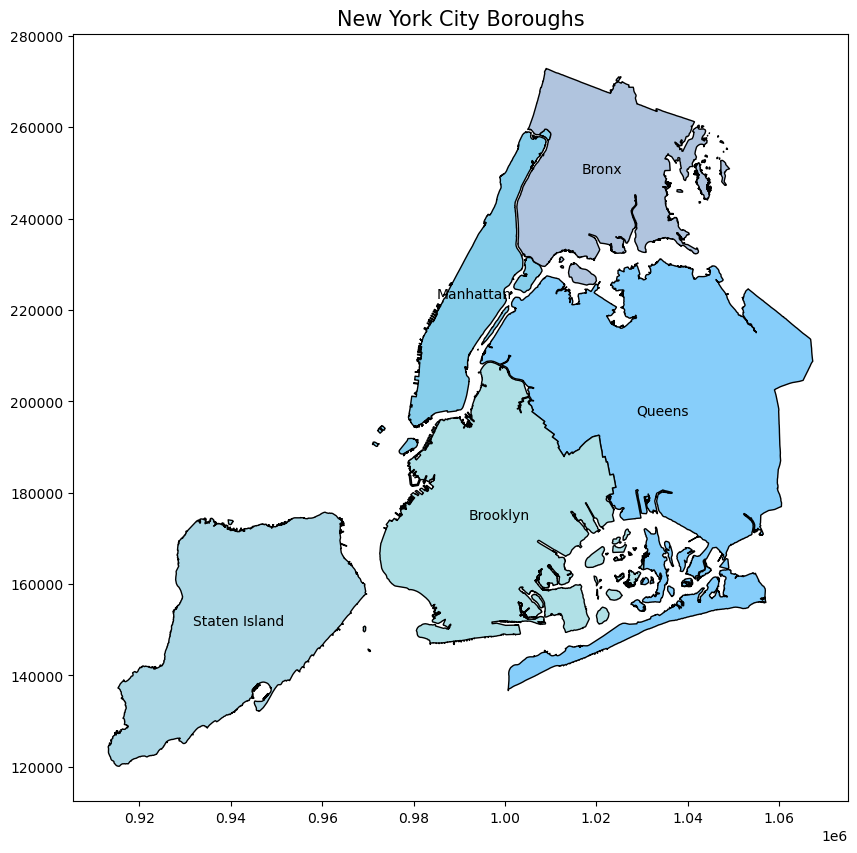

In [12]:
path_to_file = get_path('nybb')
nyc_map = gpd.read_file(path_to_file)
colors = ['#add8e6', '#87cefa', '#b0e0e6', '#87ceeb', '#b0c4de']
fig, ax = plt.subplots(figsize=(10, 10))
nyc_map.plot(ax=ax, color=colors, edgecolor='black')
nyc_map.apply(lambda x: ax.annotate(text=x['BoroName'], xy=x.geometry.centroid.coords[0], ha='center', color='black'), axis=1)
plt.title("New York City Boroughs", fontsize=15)
plt.show()

Draw the taxizone shipfile for New York

<Axes: >

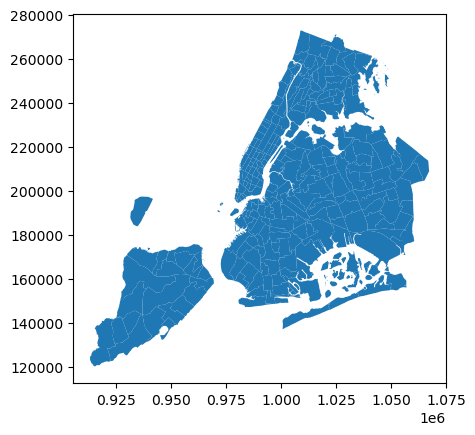

In [13]:
taxi_zones.plot()

Taxi boarding counted by zone

<Figure size 1200x800 with 0 Axes>

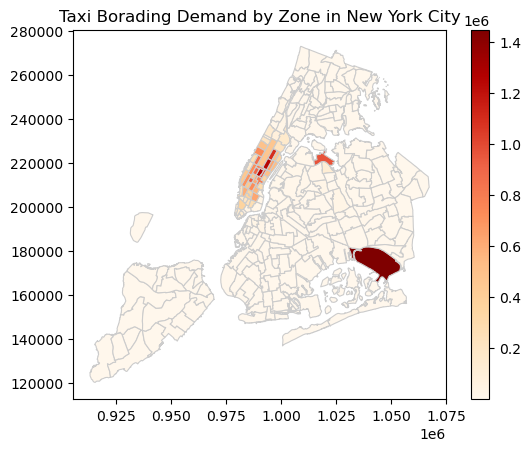

In [14]:
# Count the number of passengers in each zone of NewYork
demand_data_PUL = taxi_data_9.groupBy("PULocationID").count()
demand_data_PUL = demand_data_PUL.withColumnRenamed("count", "demand")
pandas_demand_data_PUL = demand_data_PUL.toPandas()

# Combine the zone data with the taxi demand data
taxi_zones_merge_PUL = taxi_zones.merge(pandas_demand_data_PUL, how='left', left_on='LocationID', right_on='PULocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_PUL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi Borading Demand by Zone in New York City')
plt.show()

In [15]:
# Write the top 10 zone
top_10_zones_PUL = taxi_zones_merge_PUL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_PUL

,zone,demand
131,JFK Airport,1447185.0
160,Midtown Center,1253928.0
236,Upper East Side South,1246085.0
235,Upper East Side North,1094698.0
137,LaGuardia Airport,961628.0
161,Midtown East,960874.0
185,Penn Station/Madison Sq West,928246.0
229,Times Sq/Theatre District,895858.0
141,Lincoln Square East,870117.0
169,Murray Hill,802127.0


Taxi drop-off zone count

<Figure size 1200x800 with 0 Axes>

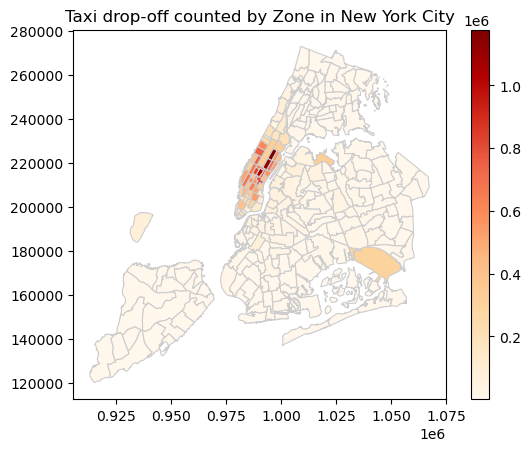

In [16]:
# Count the number of passengers in each zone of NewYork
demand_data_DOL = taxi_data_9.groupBy("DOLocationID").count()
demand_data_DOL = demand_data_DOL.withColumnRenamed("count", "demand")
pandas_demand_data_DOL = demand_data_DOL.toPandas()

# Combine the zone data with the taxi drop-off counted data
taxi_zones_merge_DOL = taxi_zones.merge(pandas_demand_data_DOL, how='left', left_on='LocationID', right_on='DOLocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_DOL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi drop-off counted by Zone in New York City')
plt.show()

In [17]:
# Write the top 10 zone
top_10_zones_DOL = taxi_zones_merge_DOL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_DOL

,zone,demand
235,Upper East Side North,1177657.0
236,Upper East Side South,1120353.0
160,Midtown Center,1041861.0
229,Times Sq/Theatre District,830793.0
169,Murray Hill,798397.0
161,Midtown East,760205.0
141,Lincoln Square East,748274.0
238,Upper West Side South,748130.0
140,Lenox Hill West,704563.0
67,East Chelsea,674912.0


## The Top 10 start station of citi Bike

In [18]:
# Count the stations with the highest number of bike 
def plot_top_stations(citybike_data, feature_name):
    start_stations_count = citybike_data.groupBy(feature_name).count().orderBy(F.desc("count")).limit(10)
    start_stations_count = start_stations_count.toPandas()
    # Draw a bar chart
    plt.figure(figsize=(20, 8))
    plt.bar(start_stations_count[feature_name], start_stations_count['count'], color='lightblue', width=0.6)
    for i in range(len(start_stations_count)):
        plt.text(i, start_stations_count['count'][i] + 100, f"{start_stations_count['count'][i]}",
                 ha='center', fontsize=15)
    plt.title(f"Top 10 {feature_name} in NewYork", fontsize=30)
    plt.xlabel("Station Name", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(rotation=20, ha="right", fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

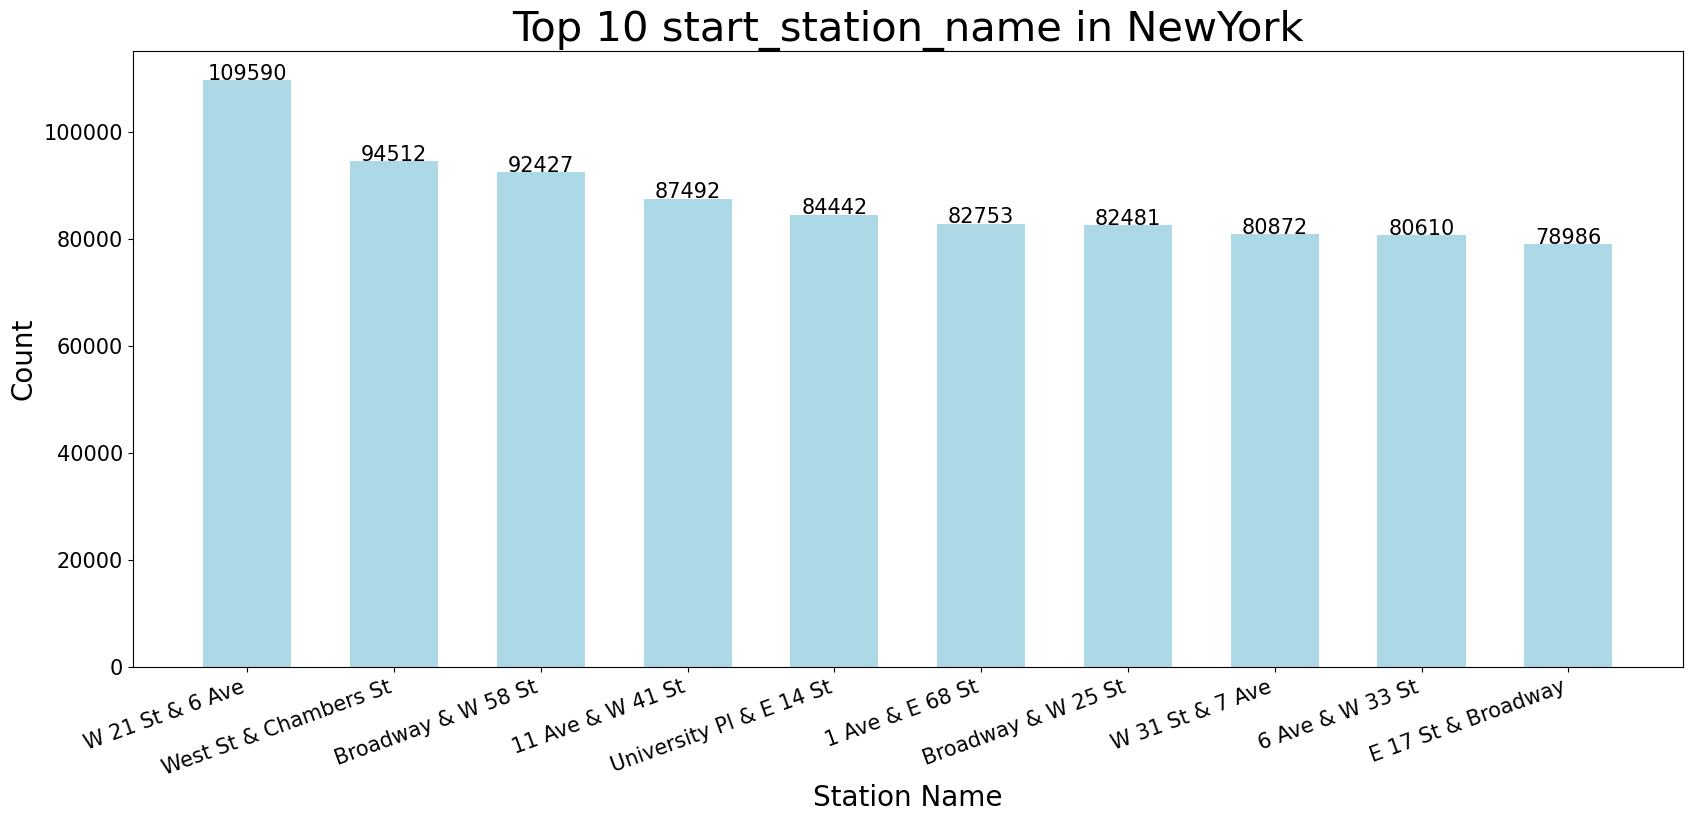

In [19]:
plot_top_stations(citybike_data_9, feature_name ='start_station_name')

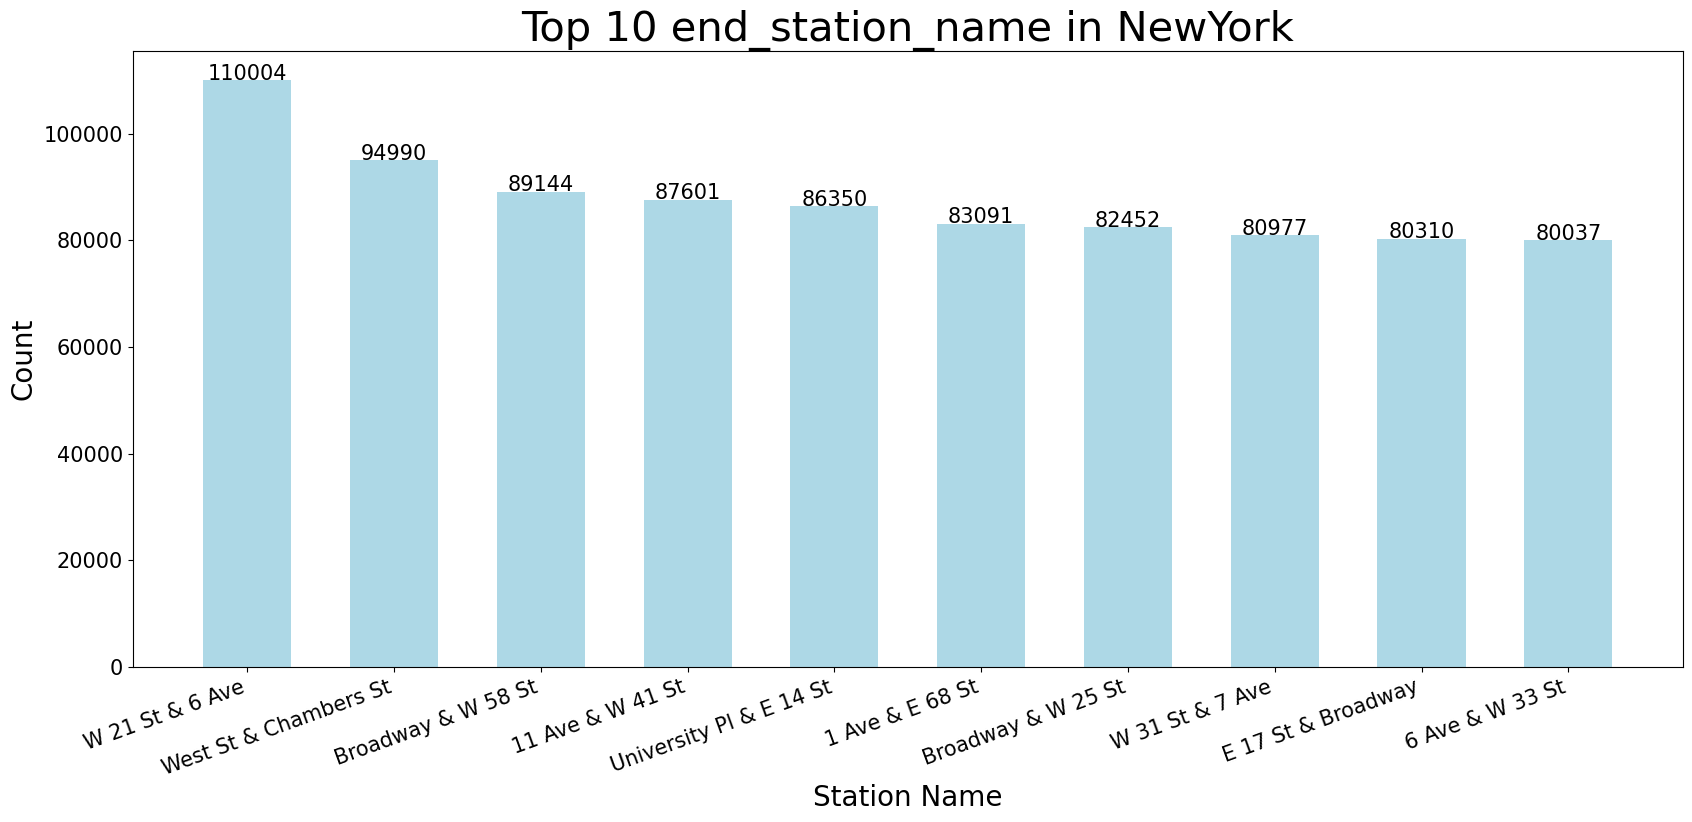

In [20]:
plot_top_stations(citybike_data_9, feature_name ='end_station_name')

## Time series segmentation

### Draw the plot for taxi/cityBike demand by day

In [21]:
# Separate the start time to date & hour
taxi_data_9 = taxi_data_9.withColumn("date", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd"))
citybike_data_9 = citybike_data_9.withColumn("date", date_format(col("started_at"), "yyyy-MM-dd"))
taxi_data_2 = taxi_data_2.withColumn("date", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd"))
citybike_data_2 = citybike_data_2.withColumn("date", date_format(col("started_at"), "yyyy-MM-dd"))

In [22]:
# Count by date
taxi_count_by_date_9 = taxi_data_9.groupBy("date").agg(count("*").alias("taxi_count")).orderBy("date").toPandas()
citybike_count_by_date_9 = citybike_data_9.groupBy("date").agg(count("*").alias("citybike_count")).orderBy("date").toPandas()
taxi_count_by_date_2 = taxi_data_2.groupBy("date").agg(count("*").alias("taxi_count")).orderBy("date").toPandas()
citybike_count_by_date_2 = citybike_data_2.groupBy("date").agg(count("*").alias("citybike_count")).orderBy("date").toPandas()

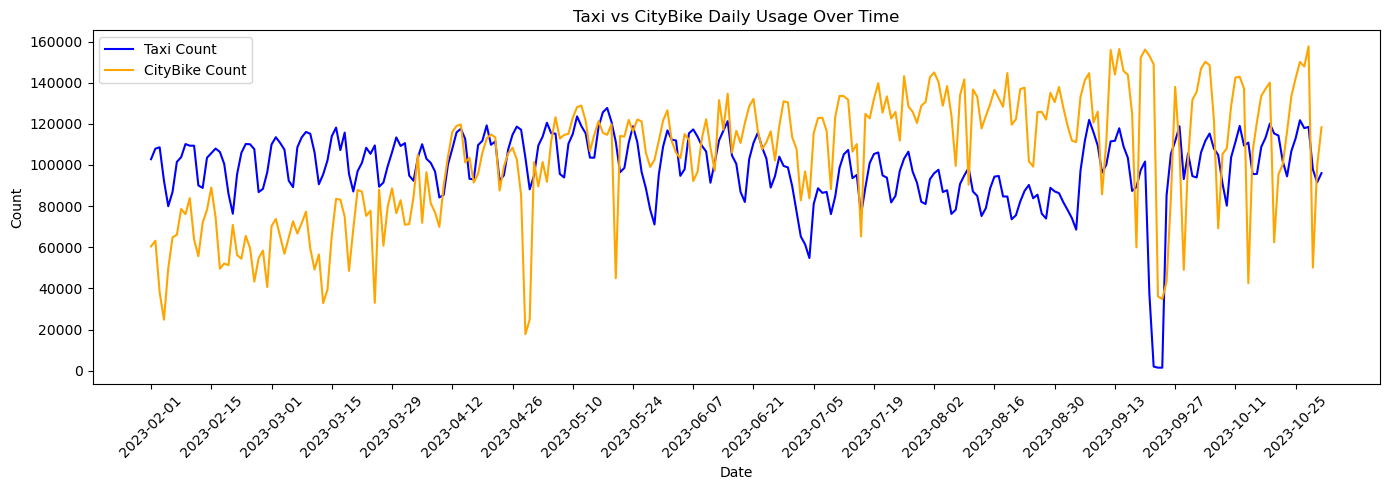

In [23]:
# Draw the time series for Taxi and CityBike data
plt.figure(figsize=(14, 5))
plt.plot(taxi_count_by_date_9["date"], taxi_count_by_date_9["taxi_count"], label="Taxi Count", color="blue")
plt.plot(citybike_count_by_date_9["date"], citybike_count_by_date_9["citybike_count"], label="CityBike Count", color="orange")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Taxi vs CityBike Daily Usage Over Time")
plt.legend()
dates = citybike_count_by_date_9["date"]
plt.xticks(ticks=range(0, len(dates), 14), labels=dates[::14], rotation=45)
plt.tight_layout()
plt.show()

### Draw the plot for taxi/cityBike demand by week

In [24]:
# Extract the hour and day of the week
taxi_data_9 = taxi_data_9.withColumn("hour", hour(col("tpep_pickup_datetime")))
taxi_data_9 = taxi_data_9.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
citybike_data_9 = citybike_data_9.withColumn("hour", hour(col("started_at")))
citybike_data_9 = citybike_data_9.withColumn("day_of_week", dayofweek(col("started_at")))
taxi_data_2 = taxi_data_2.withColumn("hour", hour(col("tpep_pickup_datetime")))
taxi_data_2 = taxi_data_2.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
citybike_data_2 = citybike_data_2.withColumn("hour", hour(col("started_at")))
citybike_data_2 = citybike_data_2.withColumn("day_of_week", dayofweek(col("started_at")))

In [25]:
# Count by date and hour
taxi_grouped_9 = taxi_data_9.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
taxi_grouped_pd_9 = taxi_grouped_9.toPandas()
citybike_grouped_9 = citybike_data_9.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
citybike_grouped_pd_9 = citybike_grouped_9.toPandas()

taxi_grouped_2 = taxi_data_2.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
taxi_grouped_pd_2 = taxi_grouped_2.toPandas()
citybike_grouped_2 = citybike_data_2.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
citybike_grouped_pd_2 = citybike_grouped_2.toPandas()

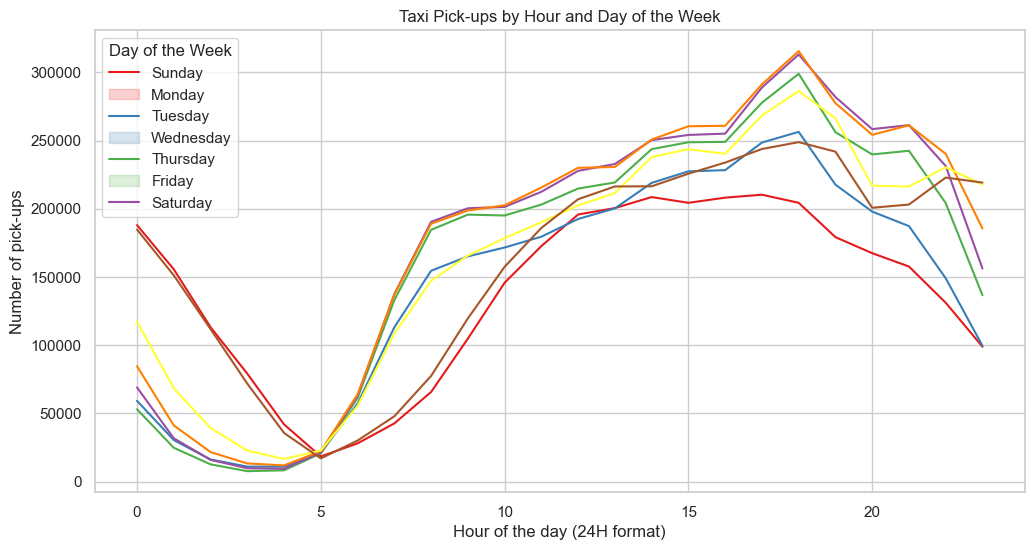

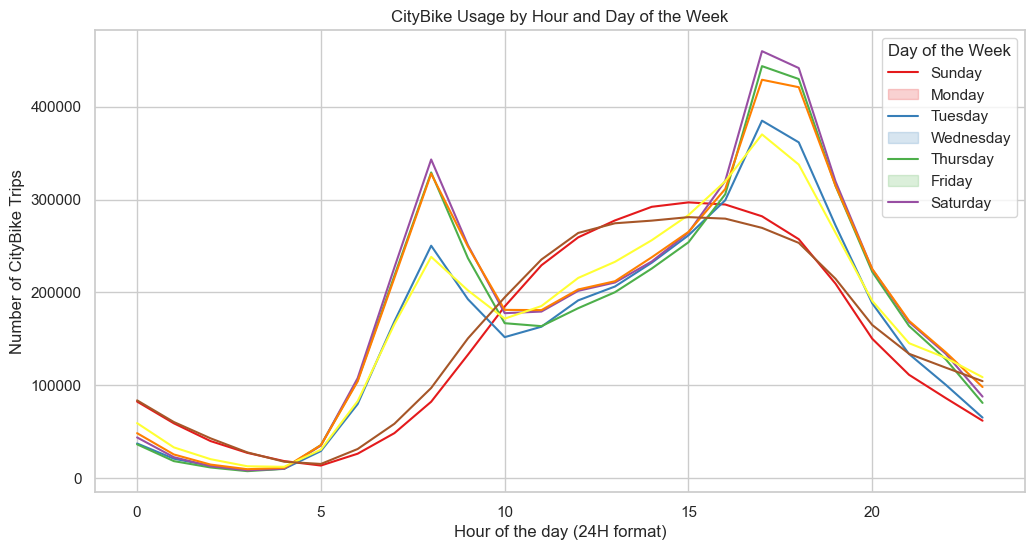

In [26]:
# Draw the plot
sns.set(style="whitegrid")

# Plot taxi usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=taxi_grouped_pd_9, palette="Set1")
plt.title("Taxi Pick-ups by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of pick-ups")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

# Plot cityBike usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=citybike_grouped_pd_9, palette="Set1")
plt.title("CityBike Usage by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of CityBike Trips")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()
